<a href="https://colab.research.google.com/github/joony0512/Linear_Programming/blob/main/%E1%84%80%E1%85%AE%E1%84%86%E1%85%A2%E1%84%87%E1%85%B5%E1%84%8B%E1%85%AD%E1%86%BC%E1%84%8B%E1%85%A8%E1%84%8E%E1%85%B3%E1%86%A8%E1%84%8B%E1%85%B3%E1%86%AF%E1%84%90%E1%85%A9%E1%86%BC%E1%84%92%E1%85%A1%E1%86%ABViplist%E1%84%87%E1%85%A7%E1%86%AF%E1%84%86%E1%85%A1%E1%84%8F%E1%85%A6%E1%84%90%E1%85%B5%E1%86%BC%E1%84%8E%E1%85%AC%E1%84%8C%E1%85%A5%E1%86%A8%E1%84%92%E1%85%AA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 55.9 MB/s eta 0:00:00


### 새로 lp 돌릴때마다 돌려야함

In [ ]:
# 데이터 불러오기
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import pandas as pd
from pulp import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint


Data =pd.read_excel('/content/drive/MyDrive/2023년 4학년 2학기/OA/기말고사/분석 데이터.xlsx')

#! Income 데이터를 수익별로 그룹화
# bins=[0,10001,20001,30001,40001,50001,60001,70001,80001,90001,100001,110001,120001,130001,140001]
start = 10001  # 시작 숫자
end = int(Data['Income'].max()+10000)  # 끝 숫자
interval = 10000
bins = [0]
for num in range(start, end + 1, interval):
    bins.append(num)
Data['Income_M_cost'] = np.digitize(Data['Income'], bins) * 100.0


#! Education과 Marital_Status를 매핑해서 그룹별 마케팅비용 추가
education_mapping = {
    'Basic': 20,
    '2n Cycle': 10,
    'Graduation': 30,
    'Master': 40,
    'PhD': 50
}
Data['Education_M_cost'] = Data['Education'].map(education_mapping).astype(int)

marital_status_mapping = {
    'Single': 30,
    'Married':50,
    'Divorced': 10,
    'Together': 10,
    'Widow': 10,
    'Alone': 10,
    'Absurd':10,
    'YOLO' : 10    
}
Data['Marital_M_cost'] = Data['Marital_Status'].map(marital_status_mapping).astype(int)

#! 현재 데이터 기준 그룹별 예측비용 Column 추가
Data['profit'] = Data['MntPurchases'] - (Data['Income_M_cost']+Data['Education_M_cost']+Data['Marital_M_cost'])

#? 결혼여부, 교육정보 변수를 숫자로 인코딩.
label_encoder = LabelEncoder()
Data['Marital_Status'] = label_encoder.fit_transform(Data['Marital_Status']) 
Data['Education'] = label_encoder.fit_transform(Data['Education'])  

features = ['Education_M_cost', 'Marital_M_cost', 'Income_M_cost']
target = 'MntPurchases'

grouped_data = Data.groupby(features).mean().reset_index()
grouped_data

,Education_M_cost,Marital_M_cost,Income_M_cost,Education,Marital_Status,Income,MntPurchases,profit
0,10,10,100.0,0.0,5.000000,7500.000000,76.500000,-43.500000
1,10,10,200.0,0.0,4.500000,15795.333333,70.833333,-149.166667
2,10,10,300.0,0.0,4.846154,25475.461538,82.923077,-237.076923
3,10,10,400.0,0.0,3.500000,34393.000000,93.125000,-326.875000
4,10,10,500.0,0.0,4.111111,45273.555556,505.555556,-14.444444
...,...,...,...,...,...,...,...,...
116,50,50,600.0,4.0,3.000000,55065.843750,534.937500,-165.062500
117,50,50,700.0,4.0,3.000000,65596.931034,1128.137931,328.137931
118,50,50,800.0,4.0,3.000000,75103.894737,1368.263158,468.263158
119,50,50,900.0,4.0,3.000000,83829.642857,1492.642857,492.642857


In [ ]:
# # 특성(독립 변수)와 타깃(종속) 분리
X = grouped_data[['Education_M_cost', 'Marital_M_cost', 'Income_M_cost']]
y = grouped_data[target]

#  훈련 세트와 테스트 세트로 나누기.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)

# Random Forest 모델 생성 및 학습
model = RandomForestRegressor(max_depth= 10, min_samples_leaf= 3, min_samples_split= 2, n_estimators= 10, random_state= 35)
model.fit(X_train, y_train)

# 예측 및 성능평가
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)

predicted_Profit = model.predict(X)

# 예측된 MntPurchases 정보 추가
grouped_data['PredictedMnt'] = predicted_Profit


# 최종 결과 확인
print(grouped_data)
print('오차:', mse)
grouped_data['marketingCost'] = grouped_data['Education_M_cost']+grouped_data['Marital_M_cost'] + grouped_data['Income_M_cost']

     Education_M_cost  Marital_M_cost  Income_M_cost  Education  \
0                  10              10          100.0        0.0   
1                  10              10          200.0        0.0   
2                  10              10          300.0        0.0   
3                  10              10          400.0        0.0   
4                  10              10          500.0        0.0   
..                ...             ...            ...        ...   
116                50              50          600.0        4.0   
117                50              50          700.0        4.0   
118                50              50          800.0        4.0   
119                50              50          900.0        4.0   
120                50              50         1000.0        4.0   

     Marital_Status        Income  MntPurchases      profit  PredictedMnt  
0          5.000000   7500.000000     76.500000  -43.500000    114.106992  
1          4.500000  15795.333333     70.83

In [ ]:
result = grouped_data.groupby(['Education_M_cost','Marital_M_cost','Income_M_cost'])[['MntPurchases','PredictedMnt']].mean().reset_index()
result

,Education_M_cost,Marital_M_cost,Income_M_cost,MntPurchases,PredictedMnt
0,10,10,100.0,76.500000,114.106992
1,10,10,200.0,70.833333,57.041476
2,10,10,300.0,82.923077,70.065049
3,10,10,400.0,93.125000,153.612001
4,10,10,500.0,505.555556,292.678858
...,...,...,...,...,...
116,50,50,600.0,534.937500,540.965515
117,50,50,700.0,1128.137931,978.353371
118,50,50,800.0,1368.263158,1318.385724
119,50,50,900.0,1492.642857,1489.807562


In [ ]:
print('오차:', mse)


오차: 4046.647150674442


### marketing cost 조절 


- 5000

In [ ]:
#객체생성
model2 = LpProblem(name='VIP', sense=LpMaximize)

#마케팅비용과 예상매출액 리스트화
marketing= grouped_data['marketingCost']
purchases= grouped_data['PredictedMnt']

#변수생성: VIP인지 아닌지
variables = [LpVariable(name=f"x{i}", lowBound=0, cat='Binary') for i in range(len(grouped_data))]

#제약식: 총 마케팅 비용 5000 이내로
model2 += LpAffineExpression([(variables[i], marketing[i] ) for i in range(len(grouped_data))]) <= 5000  

#목적식: 총 매출액 최대화
obj = LpAffineExpression([(variables[i],  purchases[i]) for i in range(len(grouped_data))])
model2 += obj

model2.solve()

print("Total Purchases:", model2.objective.value())
print()

#예상 매출액 최대화하는 segment
for i in range(len(grouped_data)):
    if variables[i].value() == 0:
        grouped_data.drop([i], axis=0, inplace=True)
        
#총마케팅비용
print('Total MaketingCost:',sum(grouped_data['marketingCost']))
print()        
        
grouped_data[['Education_M_cost','Marital_M_cost','Income_M_cost','marketingCost','MntPurchases','PredictedMnt']]

Total Purchases: 8260.659200414895

Total MaketingCost: 5000.0



,Education_M_cost,Marital_M_cost,Income_M_cost,marketingCost,MntPurchases,PredictedMnt
44,30,10,1000.0,1040.0,2181.666667,1762.987588
71,40,10,800.0,850.0,1386.384615,1366.711099
72,40,10,900.0,950.0,1570.000000,1505.833544
82,40,30,1000.0,1070.0,1998.000000,1812.563485
91,40,50,1000.0,1090.0,2219.000000,1812.563485


- 10000

In [ ]:
#객체생성
model3 = LpProblem(name='VIP', sense=LpMaximize)

#마케팅비용과 예상매출액 리스트화
marketing= grouped_data['marketingCost']
purchases= grouped_data['PredictedMnt']

#변수생성: VIP인지 아닌지
variables = [LpVariable(name=f"x{i}", lowBound=0, cat='Binary') for i in range(len(grouped_data))]

#제약식: 총 마케팅 비용 5000 이내로
model3 += LpAffineExpression([(variables[i], marketing[i] ) for i in range(len(grouped_data))]) <= 10000  

#목적식: 총 매출액 최대화
obj = LpAffineExpression([(variables[i],  purchases[i]) for i in range(len(grouped_data))])
model3 += obj

model3.solve()

print("Total Purchases:", model3.objective.value())
print()

#예상 매출액 최대화하는 segment
for i in range(len(grouped_data)):
    if variables[i].value() == 0:
        grouped_data.drop([i], axis=0, inplace=True)
        
#총마케팅비용
print('Total MaketingCost:',sum(grouped_data['marketingCost']))
print()        
        
grouped_data[['Education_M_cost','Marital_M_cost','Income_M_cost','marketingCost','MntPurchases','PredictedMnt']]

Total Purchases: 16488.33461450643

Total MaketingCost: 10000.0



,Education_M_cost,Marital_M_cost,Income_M_cost,marketingCost,MntPurchases,PredictedMnt
9,10,10,1000.0,1020.0,1263.000000,1654.744992
44,30,10,1000.0,1040.0,2181.666667,1762.987588
54,30,30,1000.0,1060.0,1789.666667,1786.391421
71,40,10,800.0,850.0,1386.384615,1366.711099
80,40,30,800.0,870.0,1624.500000,1366.711099
82,40,30,1000.0,1070.0,1998.000000,1812.563485
91,40,50,1000.0,1090.0,2219.000000,1812.563485
99,50,10,800.0,860.0,1304.454545,1366.711099
101,50,10,1000.0,1060.0,1638.000000,1767.773257
110,50,30,1000.0,1080.0,1685.000000,1791.177090


- 15000

In [ ]:
#객체생성
model3 = LpProblem(name='VIP', sense=LpMaximize)

#마케팅비용과 예상매출액 리스트화
marketing= grouped_data['marketingCost']
purchases= grouped_data['PredictedMnt']

#변수생성: VIP인지 아닌지
variables = [LpVariable(name=f"x{i}", lowBound=0, cat='Binary') for i in range(len(grouped_data))]

#제약식: 총 마케팅 비용 5000 이내로
model3 += LpAffineExpression([(variables[i], marketing[i] ) for i in range(len(grouped_data))]) <= 15000  

#목적식: 총 매출액 최대화
obj = LpAffineExpression([(variables[i],  purchases[i]) for i in range(len(grouped_data))])
model3 += obj

model3.solve()

print("Total Purchases:", model3.objective.value())
print()

#예상 매출액 최대화하는 segment
for i in range(len(grouped_data)):
    if variables[i].value() == 0:
        grouped_data.drop([i], axis=0, inplace=True)
        
#총마케팅비용
print('Total MaketingCost:',sum(grouped_data['marketingCost']))
print()        
        
grouped_data[['Education_M_cost','Marital_M_cost','Income_M_cost','marketingCost','MntPurchases','PredictedMnt']]

Total Purchases: 24471.752302129422

Total MaketingCost: 15000.0



,Education_M_cost,Marital_M_cost,Income_M_cost,marketingCost,MntPurchases,PredictedMnt
9,10,10,1000.0,1020.0,1263.000000,1654.744992
44,30,10,1000.0,1040.0,2181.666667,1762.987588
54,30,30,1000.0,1060.0,1789.666667,1786.391421
64,30,50,1000.0,1080.0,1801.571429,1786.391421
71,40,10,800.0,850.0,1386.384615,1366.711099
80,40,30,800.0,870.0,1624.500000,1366.711099
82,40,30,1000.0,1070.0,1998.000000,1812.563485
91,40,50,1000.0,1090.0,2219.000000,1812.563485
99,50,10,800.0,860.0,1304.454545,1366.711099
100,50,10,900.0,960.0,1395.230769,1507.867122


- 20000

In [ ]:
#객체생성
model3 = LpProblem(name='VIP', sense=LpMaximize)

#마케팅비용과 예상매출액 리스트화
marketing= grouped_data['marketingCost']
purchases= grouped_data['PredictedMnt']

#변수생성: VIP인지 아닌지
variables = [LpVariable(name=f"x{i}", lowBound=0, cat='Binary') for i in range(len(grouped_data))]

#제약식: 총 마케팅 비용 5000 이내로
model3 += LpAffineExpression([(variables[i], marketing[i] ) for i in range(len(grouped_data))]) <= 20000  

#목적식: 총 매출액 최대화
obj = LpAffineExpression([(variables[i],  purchases[i]) for i in range(len(grouped_data))])
model3 += obj

model3.solve()

print("Total Purchases:", model3.objective.value())
print()

#예상 매출액 최대화하는 segment
for i in range(len(grouped_data)):
    if variables[i].value() == 0:
        grouped_data.drop([i], axis=0, inplace=True)
        
#총마케팅비용
print('Total MaketingCost:',sum(grouped_data['marketingCost']))
print()        
        
grouped_data[['Education_M_cost','Marital_M_cost','Income_M_cost','marketingCost','MntPurchases','PredictedMnt']]

Total Purchases: 32152.224599177538

Total MaketingCost: 20000.0



,Education_M_cost,Marital_M_cost,Income_M_cost,marketingCost,MntPurchases,PredictedMnt
8,10,10,900.0,920.0,1267.000000,1403.150697
9,10,10,1000.0,1020.0,1263.000000,1654.744992
29,20,30,100.0,150.0,110.000000,171.488302
43,30,10,900.0,940.0,1564.387097,1463.147829
44,30,10,1000.0,1040.0,2181.666667,1762.987588
53,30,30,900.0,960.0,1419.571429,1486.551662
54,30,30,1000.0,1060.0,1789.666667,1786.391421
64,30,50,1000.0,1080.0,1801.571429,1786.391421
71,40,10,800.0,850.0,1386.384615,1366.711099
72,40,10,900.0,950.0,1570.000000,1505.833544


- 25000

In [ ]:
#객체생성
model3 = LpProblem(name='VIP', sense=LpMaximize)

#마케팅비용과 예상매출액 리스트화
marketing= grouped_data['marketingCost']
purchases= grouped_data['PredictedMnt']

#변수생성: VIP인지 아닌지
variables = [LpVariable(name=f"x{i}", lowBound=0, cat='Binary') for i in range(len(grouped_data))]

#제약식: 총 마케팅 비용 5000 이내로
model3 += LpAffineExpression([(variables[i], marketing[i] ) for i in range(len(grouped_data))]) <= 25000  

#목적식: 총 매출액 최대화
obj = LpAffineExpression([(variables[i],  purchases[i]) for i in range(len(grouped_data))])
model3 += obj

model3.solve()

print("Total Purchases:", model3.objective.value())
print()

#예상 매출액 최대화하는 segment
for i in range(len(grouped_data)):
    if variables[i].value() == 0:
        grouped_data.drop([i], axis=0, inplace=True)
        
#총마케팅비용
print('Total MaketingCost:',sum(grouped_data['marketingCost']))
print()        
        
grouped_data[['Education_M_cost','Marital_M_cost','Income_M_cost','marketingCost','MntPurchases','PredictedMnt']]

Total Purchases: 39690.52229030541

Total MaketingCost: 24990.0



,Education_M_cost,Marital_M_cost,Income_M_cost,marketingCost,MntPurchases,PredictedMnt
7,10,10,800.0,820.0,920.200000,1241.092159
8,10,10,900.0,920.0,1267.000000,1403.150697
9,10,10,1000.0,1020.0,1263.000000,1654.744992
15,10,30,800.0,840.0,1307.500000,1241.092159
42,30,10,800.0,840.0,1274.693548,1270.235637
43,30,10,900.0,940.0,1564.387097,1463.147829
44,30,10,1000.0,1040.0,2181.666667,1762.987588
52,30,30,800.0,860.0,1230.448276,1270.235637
53,30,30,900.0,960.0,1419.571429,1486.551662
54,30,30,1000.0,1060.0,1789.666667,1786.391421


- 30000

In [ ]:
#객체생성
model3 = LpProblem(name='VIP', sense=LpMaximize)

#마케팅비용과 예상매출액 리스트화
marketing= grouped_data['marketingCost']
purchases= grouped_data['PredictedMnt']

#변수생성: VIP인지 아닌지
variables = [LpVariable(name=f"x{i}", lowBound=0, cat='Binary') for i in range(len(grouped_data))]

#제약식: 총 마케팅 비용 5000 이내로
model3 += LpAffineExpression([(variables[i], marketing[i] ) for i in range(len(grouped_data))]) <= 30000  

#목적식: 총 매출액 최대화
obj = LpAffineExpression([(variables[i],  purchases[i]) for i in range(len(grouped_data))])
model3 += obj

model3.solve()

print("Total Purchases:", model3.objective.value())
print()

#예상 매출액 최대화하는 segment
for i in range(len(grouped_data)):
    if variables[i].value() == 0:
        grouped_data.drop([i], axis=0, inplace=True)
        
#총마케팅비용
print('Total MaketingCost:',sum(grouped_data['marketingCost']))
print()        
        
grouped_data[['Education_M_cost','Marital_M_cost','Income_M_cost','marketingCost','MntPurchases','PredictedMnt']]

Total Purchases: 46974.929985093484

Total MaketingCost: 29990.0



,Education_M_cost,Marital_M_cost,Income_M_cost,marketingCost,MntPurchases,PredictedMnt
7,10,10,800.0,820.0,920.200000,1241.092159
8,10,10,900.0,920.0,1267.000000,1403.150697
9,10,10,1000.0,1020.0,1263.000000,1654.744992
15,10,30,800.0,840.0,1307.500000,1241.092159
16,10,30,900.0,940.0,1335.166667,1403.150697
29,20,30,100.0,150.0,110.000000,171.488302
42,30,10,800.0,840.0,1274.693548,1270.235637
43,30,10,900.0,940.0,1564.387097,1463.147829
44,30,10,1000.0,1040.0,2181.666667,1762.987588
45,30,30,100.0,160.0,63.800000,170.239735


### 마케팅액 조절과 매출 사이 그래프

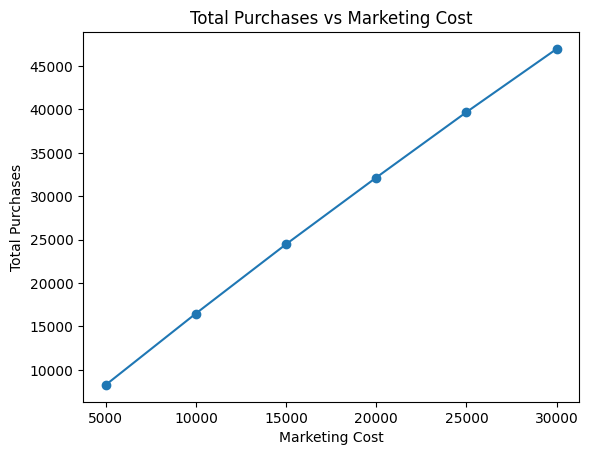

In [ ]:
import matplotlib.pyplot as plt

x = [5000, 10000, 15000, 20000, 25000, 30000]
y = [8260, 16488, 24471, 32152, 39690, 46974]

plt.plot(x, y, marker='o')
plt.xlabel('Marketing Cost')
plt.ylabel('Total Purchases')
plt.title('Total Purchases vs Marketing Cost')
plt.show()


# B 안 - 모든 세그먼트 구별


In [ ]:
# 데이터 불러오기
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import pandas as pd
# from pulp import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint
df =pd.read_excel('/content/drive/MyDrive/2023년 4학년 2학기/OA/기말고사/분석 데이터.xlsx')

In [ ]:

# 데이터 마케팅 비용화
edu_cost = {'2n Cycle': 10, 'Basic': 20, 'Graduation': 30, 'Master': 40, 'PhD': 50}
marry_cost = {'Together': 10, 'Divorced': 10, 'Widow': 10, 'Alone': 10, 'Absurd': 10, 'YOLO': 10, 'Single': 30, 'Married': 50}

#df2에서 마케팅비용만들어서 df에 가져오기
df2 = df.replace({'Education': edu_cost}) 
df2 = df2.replace({'Marital_Status': marry_cost})
df2['Income'] = pd.cut(df2['Income'], bins=range(1, df['Income'].max() + 10000, 10000), 
                        labels=[f"{(i+10000)/100}" for i in range(0, int(df['Income'].max()) + 1, 10000)])
df2['Income'] = pd.to_numeric(df2['Income'], errors='coerce') 
df2['marketingCost']=df2['Education']+df2['Marital_Status']+df2['Income']
df['marketingCost']=df2['marketingCost']

#수입 바이닝하고 숫자 타입으로 바꾸기
df['Income'] = pd.cut(df['Income'], bins=range(1, df['Income'].max() + 10000, 10000), 
                        labels=[f"{(i+10000)/100}" for i in range(0, int(df['Income'].max()) + 1, 10000)])
df['Income'] = pd.to_numeric(df['Income'], errors='coerce') 

#교육 변수 숫자로 인코딩
label_encoder = LabelEncoder()
df['Education'] = label_encoder.fit_transform(df['Education'])
edu_label=label_encoder.classes_
num=0
for i in edu_label:
    print(i,'-->',num)
    num = num+1
print()

#결혼여부 변수 숫자로 인코딩
df['Marital_Status'] = label_encoder.fit_transform(df['Marital_Status'])
marry_label=label_encoder.classes_
num2=0
for i in marry_label:
    print(i,'-->',num2)
    num2 = num2+1
print()    

#그룹핑-교육,결혼,수입,마케팅비용으로 묶고 매출 평균치
features = ['Education', 'Marital_Status', 'Income','marketingCost']
target = 'MntPurchases'
groupingData = df.groupby(features)[target].mean().reset_index()

2n Cycle --> 0
Basic --> 1
Graduation --> 2
Master --> 3
PhD --> 4

Absurd --> 0
Alone --> 1
Divorced --> 2
Married --> 3
Single --> 4
Together --> 5
Widow --> 6
YOLO --> 7



In [ ]:
groupingData


,Education,Marital_Status,Income,marketingCost,MntPurchases
0,0,2,200.0,220.0,48.000000
1,0,2,300.0,320.0,56.000000
2,0,2,400.0,420.0,51.250000
3,0,2,500.0,520.0,641.333333
4,0,2,600.0,620.0,644.000000
...,...,...,...,...,...
178,4,6,600.0,660.0,655.285714
179,4,6,700.0,760.0,799.333333
180,4,6,800.0,860.0,1141.333333
181,4,6,900.0,960.0,1409.000000
